In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import  StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Import dataset
df = pd.read_csv("data/fraudTest.csv", index_col=0)

In [3]:
df['distance'] = (((df['lat'] - df['merch_lat'])*np.cos(np.radians((df['long'] + df['merch_long'])/2)))**2 + (df['long'] - df['merch_long'])**2)**1/2*111.12
df['age'] = pd.to_numeric(2025 - pd.to_datetime(df['dob']).dt.year)
df['trans_dayofweek'] = pd.to_datetime(df['trans_date_trans_time']).dt.day_name()
df['trans_month'] = pd.to_datetime(df['trans_date_trans_time']).dt.month_name()
# df['group_merchant'] = df['merchant'].str.removeprefix("fraud_").str.split().str[0].str.split("-").str[0].str.removesuffix(",")

In [5]:
# Basic stats
print("Number of rows : {}".format(df.shape[0]))
print()

print("Display of dataset: ")
display(df.head())
print()

print("Basics statistics: ")
data_desc = df.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*df.isnull().sum()/df.shape[0])

Number of rows : 555719

Display of dataset: 


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,distance,age,trans_dayofweek,trans_month
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,...,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0,3.908568,57,Sunday,June
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,...,1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0,17.581314,35,Sunday,June
2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,...,1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0,24.307959,55,Sunday,June
3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,...,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0,0.310033,38,Sunday,June
4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,...,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0,42.008917,70,Sunday,June



Basics statistics: 


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,distance,age,trans_dayofweek,trans_month
count,555719,5.557190e+05,555719,555719,555719.000000,555719,555719,555719,555719,555719,...,555719,555719,5.557190e+05,555719.000000,555719.000000,555719.000000,555719.000000,555719.000000,555719,555719
unique,544760,NaN,693,14,NaN,341,471,2,924,849,...,910,555719,NaN,NaN,NaN,NaN,NaN,NaN,7,7
top,2020-10-05 19:37:49,NaN,fraud_Kilback LLC,gas_transport,NaN,Christopher,Smith,F,444 Robert Mews,Birmingham,...,1977-03-23,1765bb45b3aa3224b4cdcb6e7a96cee3,NaN,NaN,NaN,NaN,NaN,NaN,Monday,December
freq,4,NaN,1859,56370,NaN,11443,12146,304886,1474,2423,...,2408,1,NaN,NaN,NaN,NaN,NaN,NaN,115136,139538
mean,NaN,4.178387e+17,NaN,NaN,69.392810,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.380679e+09,38.542798,-90.231380,0.003860,19.502532,51.636237,NaN,NaN
std,NaN,1.309837e+18,NaN,NaN,156.745941,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.201104e+06,5.095829,13.733071,0.062008,16.719314,17.418528,NaN,NaN
min,NaN,6.041621e+10,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.371817e+09,19.027422,-166.671575,0.000000,0.000023,20.000000,NaN,NaN
25%,NaN,1.800429e+14,NaN,NaN,9.630000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.376029e+09,34.755302,-96.905129,0.000000,4.493184,38.000000,NaN,NaN
50%,NaN,3.521417e+15,NaN,NaN,47.290000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.380762e+09,39.376593,-87.445204,0.000000,14.997347,50.000000,NaN,NaN
75%,NaN,4.635331e+15,NaN,NaN,83.010000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.385867e+09,41.954163,-80.264637,0.000000,32.307773,63.000000,NaN,NaN



Percentage of missing values: 


trans_date_trans_time    0.0
cc_num                   0.0
merchant                 0.0
category                 0.0
amt                      0.0
first                    0.0
last                     0.0
gender                   0.0
street                   0.0
city                     0.0
state                    0.0
zip                      0.0
lat                      0.0
long                     0.0
city_pop                 0.0
job                      0.0
dob                      0.0
trans_num                0.0
unix_time                0.0
merch_lat                0.0
merch_long               0.0
is_fraud                 0.0
distance                 0.0
age                      0.0
trans_dayofweek          0.0
trans_month              0.0
dtype: float64

In [6]:
df_prep = df.drop(columns=['trans_date_trans_time', 'unix_time','first', 'last', 'street', 'city','lat', 'long', 'job', 'dob', 'merchant', 'merch_lat', 'merch_long', 'trans_num'])

In [7]:
# Basic stats
print("Number of rows : {}".format(df_prep.shape[0]))
print()

print("Display of dataset: ")
display(df_prep.head())
print()

print("Basics statistics: ")
data_desc = df_prep.describe(include='all')
display(data_desc)
print()

Number of rows : 555719

Display of dataset: 


,cc_num,category,amt,gender,state,zip,city_pop,is_fraud,distance,age,trans_dayofweek,trans_month
0,2291163933867244,personal_care,2.86,M,SC,29209,333497,0,3.908568,57,Sunday,June
1,3573030041201292,personal_care,29.84,F,UT,84002,302,0,17.581314,35,Sunday,June
2,3598215285024754,health_fitness,41.28,F,NY,11710,34496,0,24.307959,55,Sunday,June
3,3591919803438423,misc_pos,60.05,M,FL,32780,54767,0,0.310033,38,Sunday,June
4,3526826139003047,travel,3.19,M,MI,49632,1126,0,42.008917,70,Sunday,June



Basics statistics: 


,cc_num,category,amt,gender,state,zip,city_pop,is_fraud,distance,age,trans_dayofweek,trans_month
count,5.557190e+05,555719,555719.000000,555719,555719,555719.000000,5.557190e+05,555719.000000,555719.000000,555719.000000,555719,555719
unique,NaN,14,NaN,2,50,NaN,NaN,NaN,NaN,NaN,7,7
top,NaN,gas_transport,NaN,F,TX,NaN,NaN,NaN,NaN,NaN,Monday,December
freq,NaN,56370,NaN,304886,40393,NaN,NaN,NaN,NaN,NaN,115136,139538
mean,4.178387e+17,NaN,69.392810,NaN,NaN,48842.628015,8.822189e+04,0.003860,19.502532,51.636237,NaN,NaN
std,1.309837e+18,NaN,156.745941,NaN,NaN,26855.283328,3.003909e+05,0.062008,16.719314,17.418528,NaN,NaN
min,6.041621e+10,NaN,1.000000,NaN,NaN,1257.000000,2.300000e+01,0.000000,0.000023,20.000000,NaN,NaN
25%,1.800429e+14,NaN,9.630000,NaN,NaN,26292.000000,7.410000e+02,0.000000,4.493184,38.000000,NaN,NaN
50%,3.521417e+15,NaN,47.290000,NaN,NaN,48174.000000,2.408000e+03,0.000000,14.997347,50.000000,NaN,NaN
75%,4.635331e+15,NaN,83.010000,NaN,NaN,72011.000000,1.968500e+04,0.000000,32.307773,63.000000,NaN,NaN


In [8]:
# Separate target variable Y from features X
print("Separating labels from features...")

features_list = df_prep.drop(columns=['is_fraud']).columns.tolist()
target_variable = 'is_fraud'
X = df_prep.loc[:,features_list]
Y = df_prep.loc[:,target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

Separating labels from features...
...Done.

Y : 
0    0
1    0
2    0
3    0
4    0
Name: is_fraud, dtype: int64

X :
             cc_num        category    amt gender state    zip  city_pop  \
0  2291163933867244   personal_care   2.86      M    SC  29209    333497   
1  3573030041201292   personal_care  29.84      F    UT  84002       302   
2  3598215285024754  health_fitness  41.28      F    NY  11710     34496   
3  3591919803438423        misc_pos  60.05      M    FL  32780     54767   
4  3526826139003047          travel   3.19      M    MI  49632      1126   

    distance  age trans_dayofweek trans_month  
0   3.908568   57          Sunday        June  
1  17.581314   35          Sunday        June  
2  24.307959   55          Sunday        June  
3   0.310033   38          Sunday        June  
4  42.008917   70          Sunday        June  


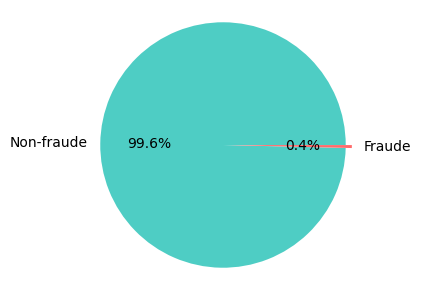

In [20]:
# Y.value_counts(normalize=True)
# # Visualize class distribution
# Y.value_counts(normalize=True).plot(kind='pie', title='Class Distribution', legend=True)
# plt.show()

plt.figure(figsize=(4, 3))
colors = ['#4ecdc4','#ff6b6b']  # Rouge pour fraude, turquoise pour non-fraude
explode = (0.05, 0)  # Légèrement séparer la première tranche

plt.pie(Y.value_counts().values, 
        labels=['Fraude' if val else 'Non-fraude' for val in Y.value_counts().index],
        autopct='%1.1f%%',  # Afficher les pourcentages avec 1 décimale
        startangle=0,
        colors=colors,
        explode=explode)

plt.axis('equal')  # Assure que le camembert est circulaire
plt.tight_layout()
plt.show()

In [21]:
## Statify splitting when you're training a classification model !
X_train, X_test, Y_train, Y_test = train_test_split(X ,Y ,test_size = 0.2, stratify = Y, random_state = 42)

In [22]:
numeric_features = []
categorical_features = []
# Assurez-vous que X est votre DataFrame
for col_name in X.columns:
    dtype = X[col_name].dtype
    if dtype in ['int64', 'float64', 'int32', 'float32']:
        numeric_features.append(col_name)
    elif dtype == 'bool':
        numeric_features.append(col_name)  # Ou categorical_features.append(col_name) selon le traitement souhaité
    else:  # pour 'object' et d'autres types non numériques
        categorical_features.append(col_name)

print('Found numeric features:', numeric_features)
print('Found categorical features:', categorical_features)

Found numeric features: ['cc_num', 'amt', 'zip', 'city_pop', 'distance', 'age']
Found categorical features: ['category', 'gender', 'state', 'trans_dayofweek', 'trans_month']


In [23]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer()), 
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5]) 
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head()) 
X_test = preprocessor.transform(X_test) # Don't fit again !! 
print('...Done.')
print(X_test[0:5,:])

Performing preprocessings on train set...
                  cc_num       category     amt gender state    zip  city_pop  \
219591  6011382886333463  entertainment   18.25      M    MI  48636       864   
385043   370877495212014    grocery_pos  192.53      F    NC  28659     21134   
270811  3566373869538620  gas_transport   43.90      M    NM  87540       923   
270180  6517217825320610       misc_net    1.25      M    MS  39665      1196   
551235   213125815021702         travel    9.99      M    NY  12410       397   

         distance  age trans_dayofweek trans_month  
219591  31.890992   83          Monday   September  
385043  48.289163   41       Wednesday    November  
270811  50.348752   61         Tuesday   September  
270180  10.237800   67         Tuesday   September  
551235  13.326942   94       Wednesday    December  
...Done.
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 53 stored elements and shape (5, 81)>
  Coords	Values
  (0, 0)	-0.3149978914160506

In [24]:
weights = {1:9,0:1}
classifier = LogisticRegression(class_weight=weights, C=15, max_iter=100)
# classifier = LogisticRegression(max_iter=500)
classifier.fit(X_train, Y_train)

LogisticRegression(C=15, class_weight={0: 1, 1: 9})

In [25]:
# The method .score() from LogisticRegression() returns the accuracy!
print('Train accuracy : {}\nTest accuracy : {}'.format(classifier.score(X_train, Y_train), classifier.score(X_test, Y_test)))

Train accuracy : 0.9945363549457347
Test accuracy : 0.9946195926005902


In [26]:
scores = cross_val_score(classifier,X_train, Y_train, cv=10)
avg = scores.mean()
std = scores.std()
print('Cross-validated accuracy : {}\nstandard deviation : {}'.format(avg, std))

Cross-validated accuracy : 0.9945161111447082
standard deviation : 0.00030821229882669287


In [27]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred[:5])
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on training set...")
Y_train_proba = classifier.predict_proba(X_train)
print("...Done.")
print(Y_train_proba[:5])
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred[:5])
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on test set...")
Y_test_proba = classifier.predict_proba(X_test)
print("...Done.")
print(Y_test_proba[:5])
print()

Predictions on training set...
...Done.
[0 0 0 0 0]

Probabilities on training set...
...Done.
[[0.99508108 0.00491892]
 [0.85640273 0.14359727]
 [0.97542558 0.02457442]
 [0.98062364 0.01937636]
 [0.99709776 0.00290224]]

Predictions on test set...
...Done.
[0 0 0 0 0]

Probabilities on test set...
...Done.
[[0.99492857 0.00507143]
 [0.98879581 0.01120419]
 [0.98645189 0.01354811]
 [0.98630184 0.01369816]
 [0.98425054 0.01574946]]



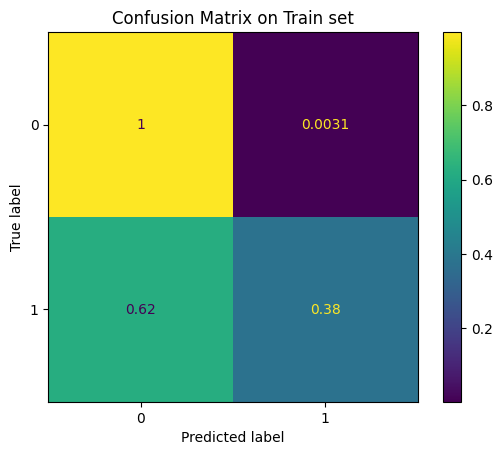

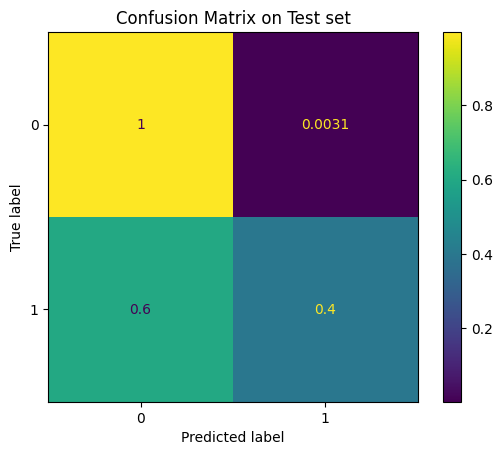

In [38]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_train, Y_train, ax=ax, normalize='true') # ConfusionMatrixDisplay from sklearn
# taille de la figure
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_test, Y_test, ax=ax, normalize='true') # ConfusionMatrixDisplay from sklearn
plt.show()

In [40]:
# le jeu de données est déséquilibré car pas beaucoup de fraudes représentées dans les datas.
# on va essayer d'améliorer les performances en mettant des poids 

# recherche des hyperparamètre
# Perform grid search
print("Grid search...")
weights = {1:9,0:1}
classifier = LogisticRegression(class_weight=weights)

# Grid of values to be tested
params = {
    'C': [1, 5, 10, 15, 20],
    'max_iter' : [100, 500, 1000]
}
gridsearch = GridSearchCV(classifier, param_grid = params, cv = 3, verbose=2) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Grid search...
Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] END ..................................C=1, max_iter=100; total time=   1.0s
[CV] END ..................................C=1, max_iter=100; total time=   1.2s
[CV] END ..................................C=1, max_iter=100; total time=   1.3s
[CV] END ..................................C=1, max_iter=500; total time=   0.9s
[CV] END ..................................C=1, max_iter=500; total time=   1.1s
[CV] END ..................................C=1, max_iter=500; total time=   1.3s
[CV] END .................................C=1, max_iter=1000; total time=   0.9s
[CV] END .................................C=1, max_iter=1000; total time=   1.3s
[CV] END .................................C=1, max_iter=1000; total time=   1.3s
[CV] END ..................................C=5, max_iter=100; total time=   1.6s
[CV] END ..................................C=5, max_iter=100; total time=   1.2s
[CV] END ........................

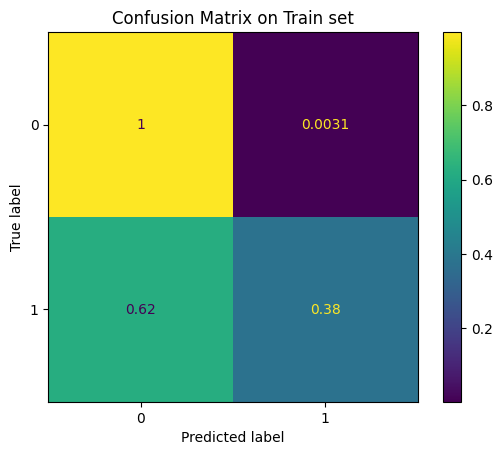

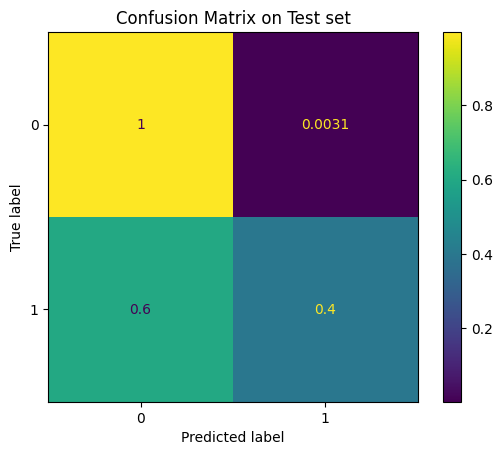

In [41]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch, X_train, Y_train, ax=ax, normalize='true') # ConfusionMatrixDisplay from sklearn
# taille de la figure
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch, X_test, Y_test, ax=ax, normalize='true') # ConfusionMatrixDisplay from sklearn
plt.show()

In [46]:
forest_classifier = RandomForestClassifier(n_estimators=10, min_samples_split=2)
forest_classifier.fit(X_train,Y_train)

RandomForestClassifier(n_estimators=10)

In [47]:
scores = cross_val_score(forest_classifier,X_train, Y_train, cv=10)
avg = scores.mean()
std = scores.std()
print('Cross-validated accuracy : {}\nstandard deviation : {}'.format(avg, std))

Cross-validated accuracy : 0.9978361350277402
standard deviation : 0.00010542050137370238


In [48]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = forest_classifier.predict(X_train)
print("...Done.")
print(Y_train_pred[:5])
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on training set...")
Y_train_proba = forest_classifier.predict_proba(X_train)
print("...Done.")
print(Y_train_proba[:5])
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = forest_classifier.predict(X_test)
print("...Done.")
print(Y_test_pred[:5])
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on test set...")
Y_test_proba = forest_classifier.predict_proba(X_test)
print("...Done.")
print(Y_test_proba[:5])
print()

Predictions on training set...
...Done.
[0 0 0 0 0]

Probabilities on training set...
...Done.
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]

Predictions on test set...
...Done.
[0 0 0 0 0]

Probabilities on test set...
...Done.
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]



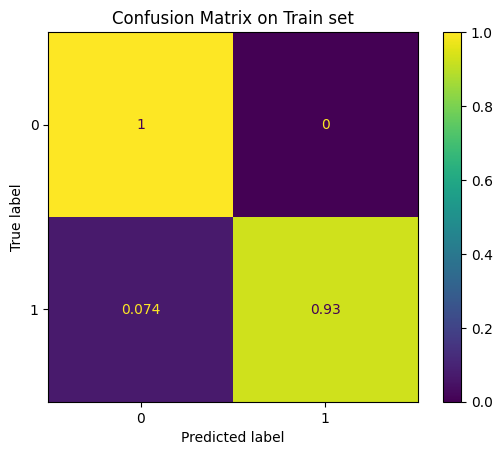

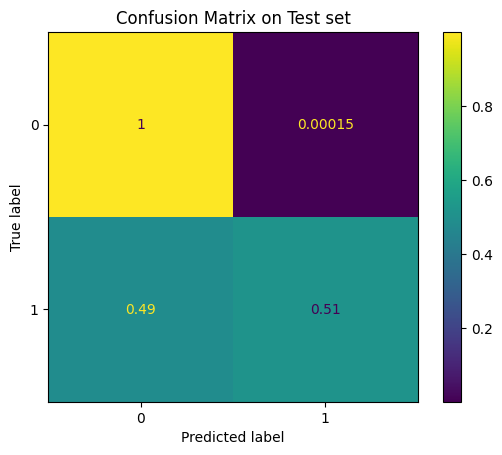

In [49]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(forest_classifier, X_train, Y_train, ax=ax, normalize='true') # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(forest_classifier, X_test, Y_test, ax=ax, normalize='true') # ConfusionMatrixDisplay from sklearn
plt.show()